## Analysis of best-performing model: ProdLDA optimized with OPTUNA

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ChiLit_Topic_Modeling

Mounted at /content/drive
/content/drive/MyDrive/ChiLit_Topic_Modeling


In [ ]:
!pip install dash

In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import networkx as nx
from wordcloud import WordCloud
import json

### Load datasets and final model

In [3]:
chunk_size = 200
octis_folder = f"./octis_{chunk_size}/"
optuna_folder = f"./optuna_{chunk_size}/"

In [6]:
df_metadata = pd.read_csv("./data/ChiLit_metadata.csv", encoding="utf-8")
df_authors = pd.read_csv("./data/ChiLit_Authors.csv", encoding="utf-8")

In [7]:
# Check choerence of authors
set(df_metadata['author'].to_list())
df_authors['author'].to_list()
z = set(df_metadata['author'].to_list()).difference(set(df_authors['author'].to_list()))
assert len(z) == 0

In [8]:
df_chilit = pd.read_csv(f"./data/ChiLit_Chunks_{chunk_size}.csv")
df_chilit = df_chilit.fillna("")

In [9]:
# ProdLDA model optimized by OPTUNA
final_model = pickle.load(open(optuna_folder + "Optuna_ProdLDA_output.pkl", "rb"))
# Matrices model outpus
final_model.keys()

dict_keys(['topics', 'topic-document-matrix', 'topic-word-matrix'])

### Labels and explanations of topics (by ChatGPT)

In [10]:
with open(optuna_folder + "/ProdLDA_Topic_Labels.json", 'r') as file:
  labels = json.load(file)

In [11]:
topic_labels = [value['primary_label'] for value in labels.values()]

In [12]:
for key, value in labels.items():
    print("\n---------------------------------")
    print(f"Topic {key} - Words: {final_model['topics'][int(key)]}")
    print(f"Label: {value['primary_label']} \nExplanation: {value['explanation']}")


---------------------------------
Topic 0 - Words: ['force', 'enemy', 'attack', 'troops', 'order', 'french', 'march', 'advance', 'army', 'number']
Label: Military Engagements 
Explanation: This topic represents the strategic and tactical aspects of military confrontations, focusing on troop movements, attacks, and the dynamics between opposing forces, particularly in historical contexts involving French and English armies.

---------------------------------
Topic 1 - Words: ['face', 'arm', 'voice', 'heart', 'tear', 'eye', 'hand', 'lay', 'speak', 'bed']
Label: Loss and Grief 
Explanation: This topic represents the emotional experiences of loss, mourning, and the deep connections between family members, particularly in the context of children and their parents. The documents reflect themes of sorrow, the fragility of life, and the longing for connection amidst tragedy.

---------------------------------
Topic 2 - Words: ['dragon', 'red', 'buy', 'engine', 'let', 'gold', 'birthday', 'tea'

### Topic word analysis

In [ ]:
with open(octis_folder + "vocab.json", 'r') as file:
  vocabulary = json.load(file)

In [ ]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Stabilizing to prevent overflow
    return exp_x / np.sum(exp_x)

topic_word_probs = []
for topic_id, topic in enumerate(final_model['topics']):
    topic_word_logits = []
    for word in topic:
        topic_word_logits.append(final_model['topic-word-matrix'][topic_id][vocabulary.index(word)])
    # Convert logits to probabilities
    topic_word_probs.append(softmax(topic_word_logits))


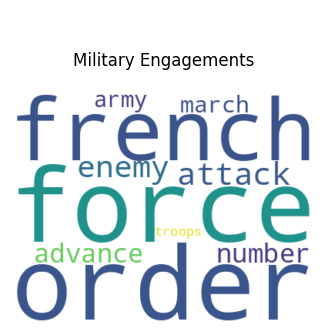

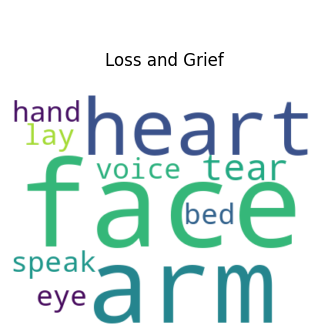

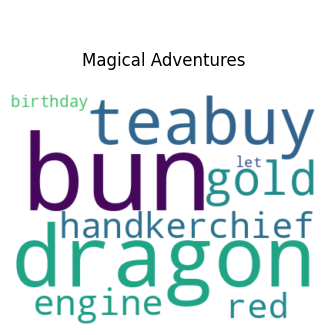

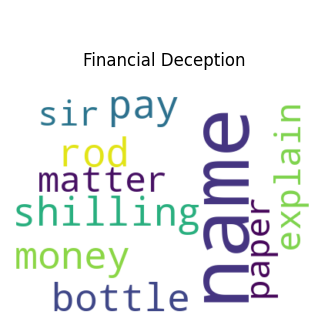

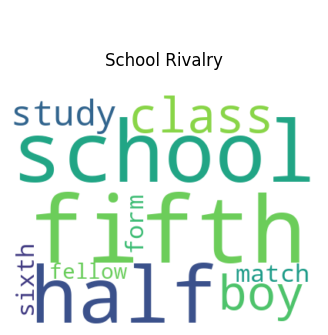

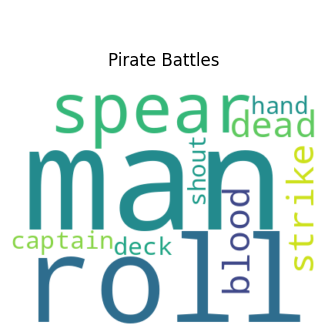

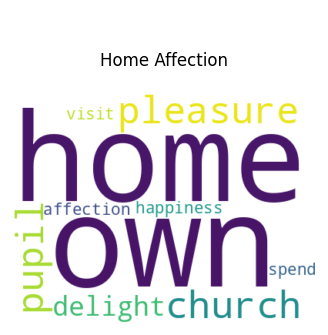

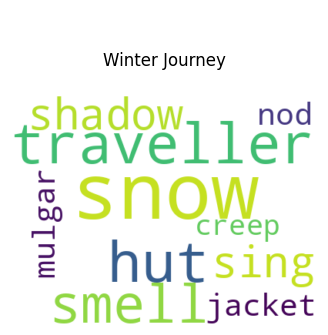

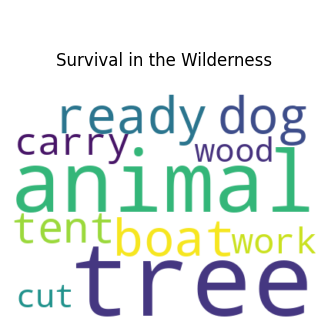

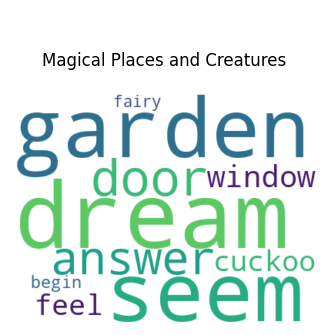

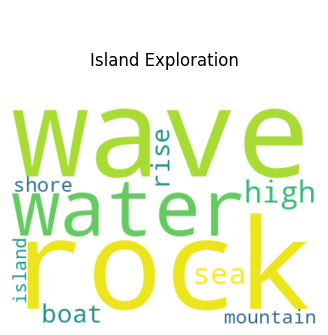

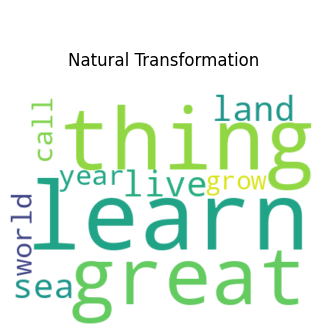

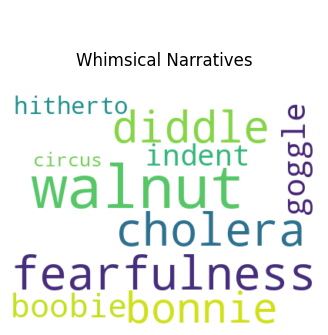

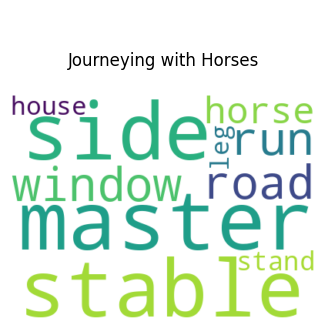

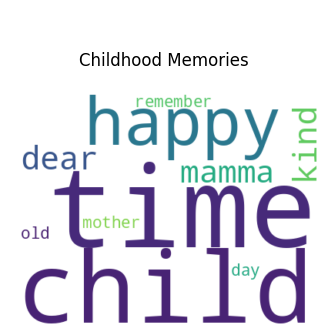

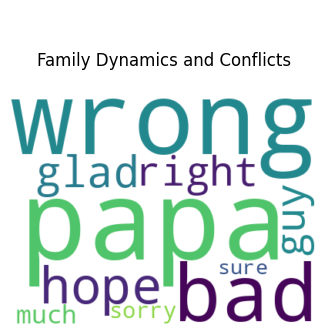

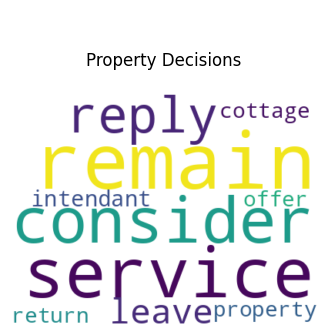

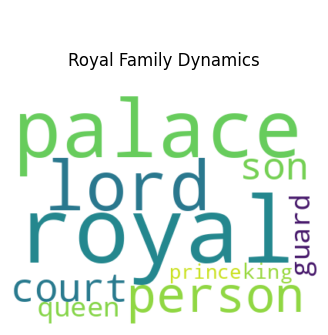

In [ ]:
# Wordclouds
for topic_id, topic in enumerate(final_model['topics']):
    freqs = {word: topic_word_probs[topic_id][word_id] for word_id, word in enumerate(topic)}
    wc = WordCloud(width=400, height=300, background_color="white").generate_from_frequencies(freqs)
    plt.figure(figsize=(4,3))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("\n\n" + labels[str(topic_id)]['primary_label'] + "\n")
    plt.show()

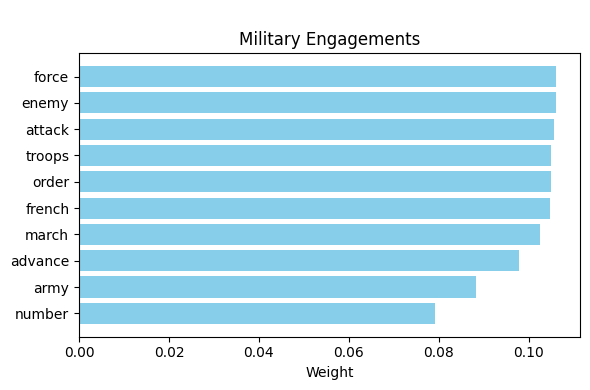

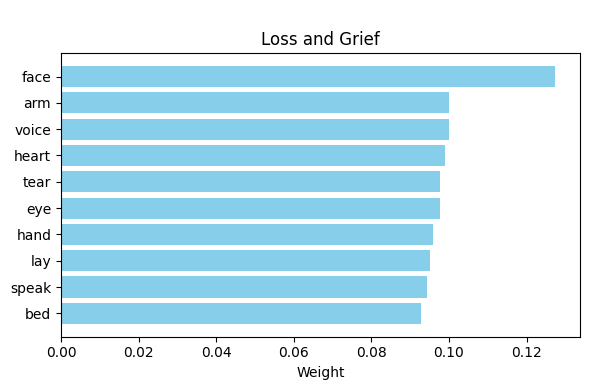

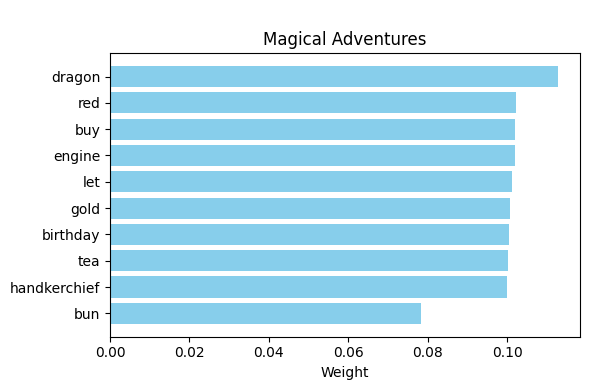

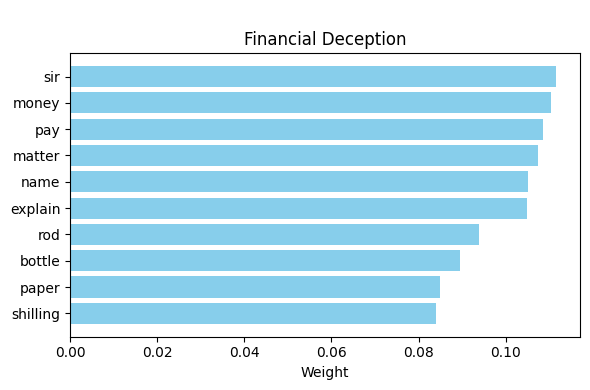

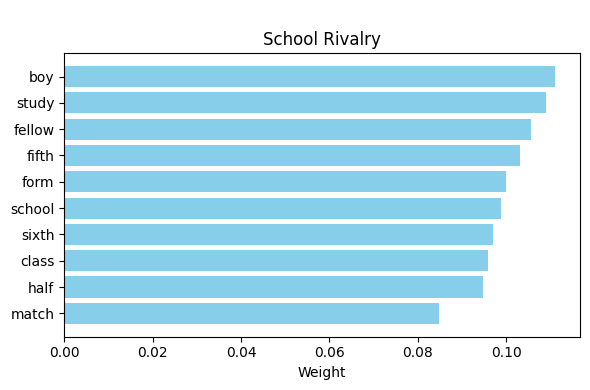

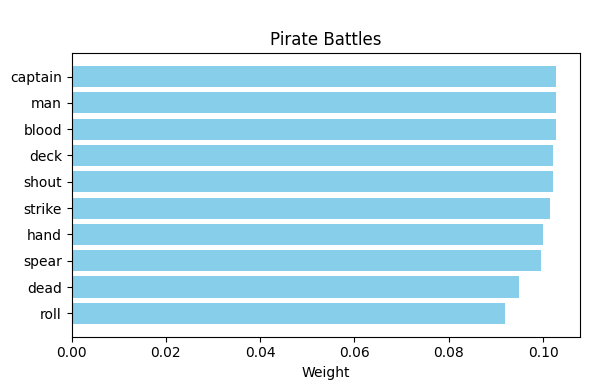

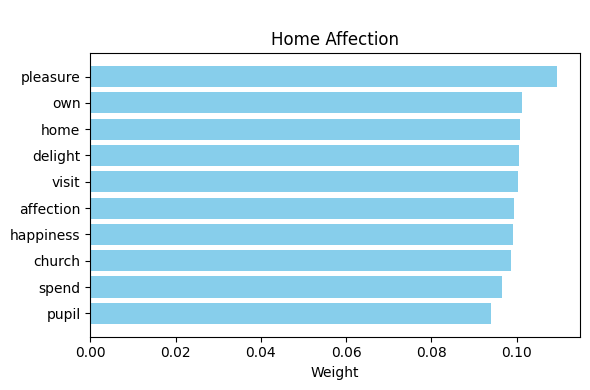

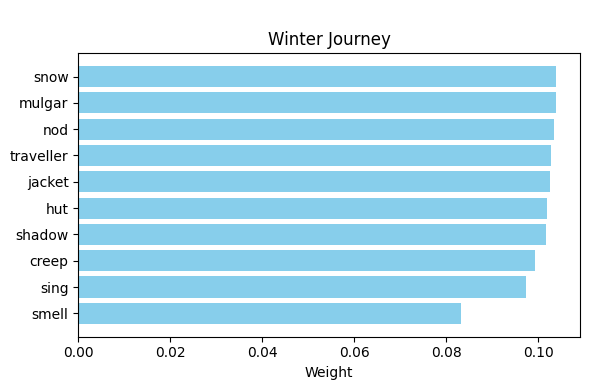

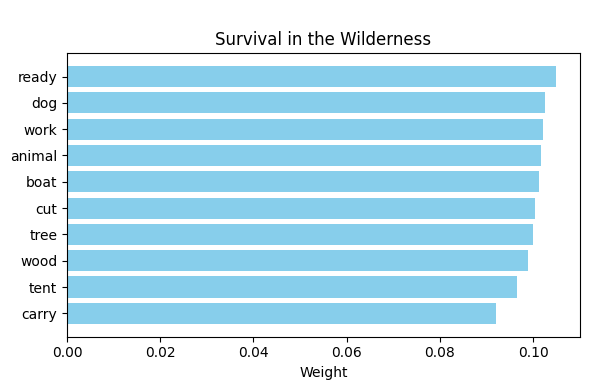

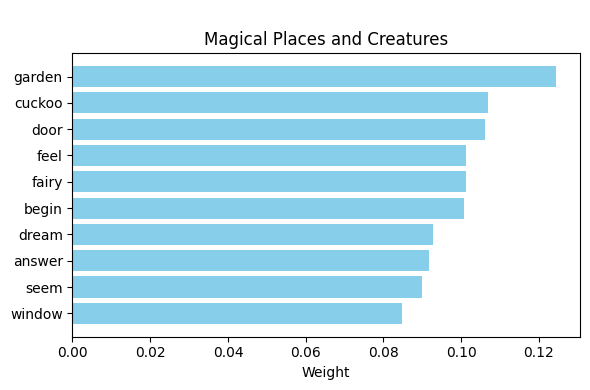

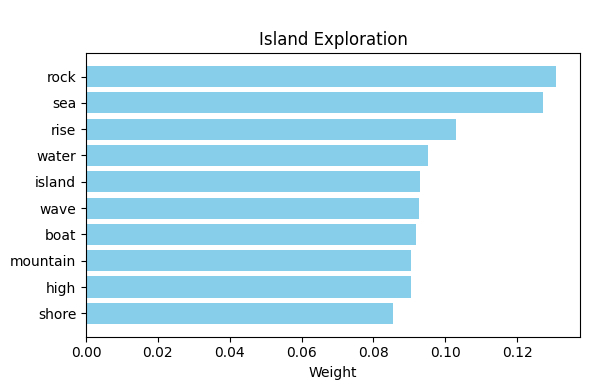

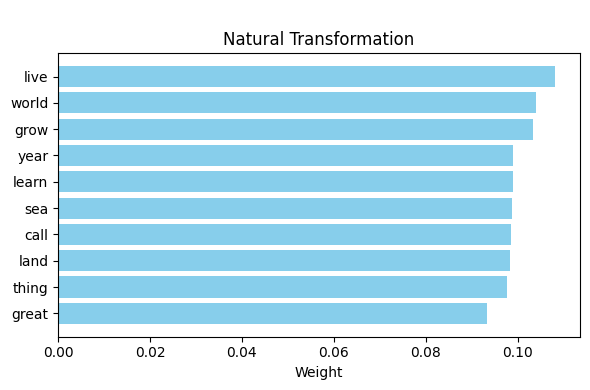

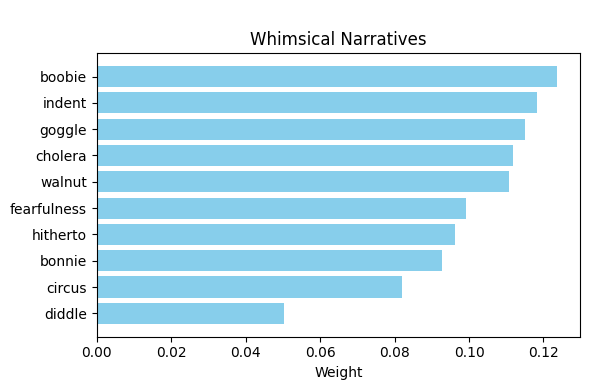

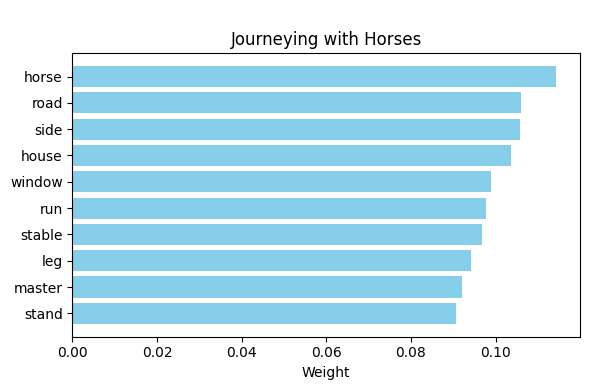

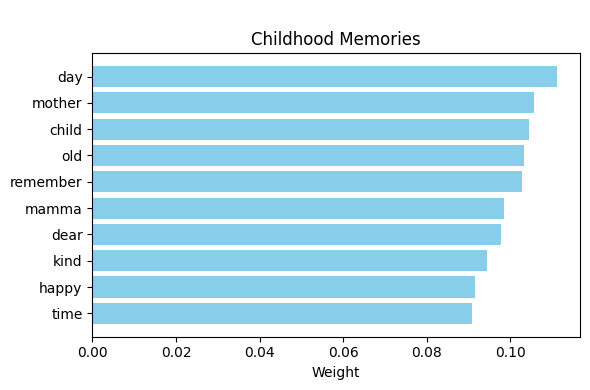

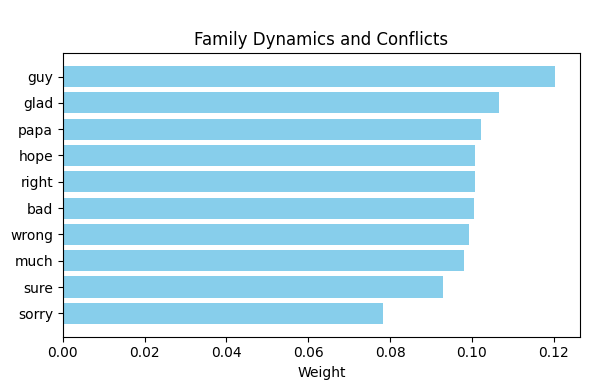

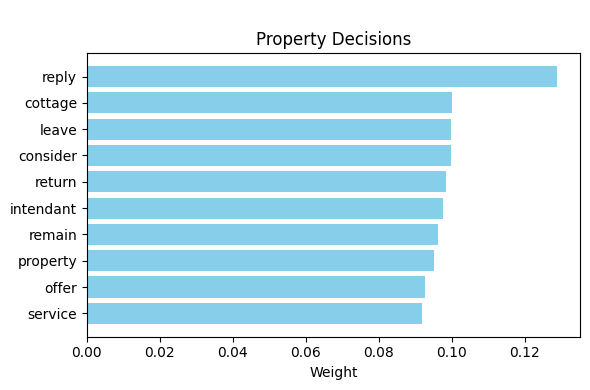

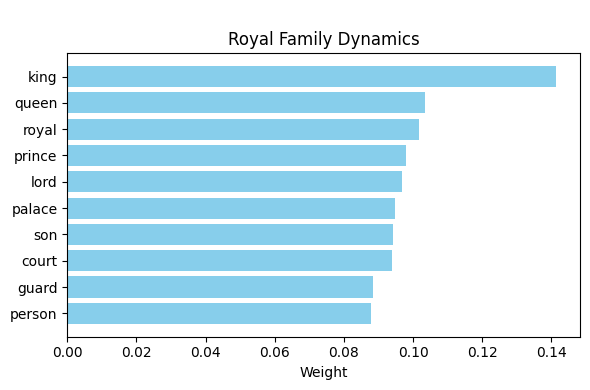

In [ ]:
# Word importance barcharts
top_n = 10
for topic_id, topic in enumerate(final_model['topics']):
    term_weights = topic_word_probs[topic_id]
    top_indices = term_weights.argsort()[::-1][:top_n]
    top_words = topic
    top_scores = term_weights[top_indices]

    plt.figure(figsize=(6, 4))
    plt.barh(top_words, top_scores, color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("\n" + labels[str(topic_id)]['primary_label'])
    plt.xlabel("Weight")
    plt.tight_layout()
    plt.show()

#### Topic embedding

In [17]:
from sentence_transformers import SentenceTransformer
# Topics
topics = final_model['topics']

# Labels
topic_labels = [value['primary_label'] for key, value in labels.items()]

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed each topic as a single sentence
topic_sentences = [" ".join(t) for t in topics]
topic_embeddings = model.encode(topic_sentences)


topic_embeddings = np.array(topic_embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [42]:
topic_embeddings

array([[-0.05796521, -0.03162387,  0.03789521, ..., -0.01949574,
         0.02770428, -0.04810759],
       [ 0.00211273, -0.03209745,  0.07316548, ...,  0.05680977,
        -0.03376116, -0.01524136],
       [-0.11320024,  0.07980897,  0.01927285, ..., -0.05466258,
         0.02189889, -0.01122996],
       ...,
       [-0.03066149,  0.02302028,  0.03624745, ..., -0.01112094,
         0.08886381,  0.01505805],
       [ 0.00365874, -0.00469799,  0.04798514, ..., -0.05967579,
        -0.03835248, -0.10379939],
       [-0.07527499,  0.09820362, -0.03643999, ..., -0.06384412,
        -0.02757213, -0.03417621]], dtype=float32)

In [29]:
similarity_matrix = cosine_similarity(topic_embeddings)
np.fill_diagonal(similarity_matrix, 0)

In [32]:
#similarity_matrix = cosine_similarity(final_model['topic-word-matrix'])

In [45]:
# Create graph
G = nx.Graph()

# Add nodes
for i, label in enumerate(topic_labels):
    G.add_node(i, label=label)

# Add edges if similarity > threshold
threshold = 0.6  # adjust threshold
for i in range(len(topic_labels)):
    for j in range(i+1, len(topic_labels)):
        sim = similarity_matrix[i, j]
        if sim > threshold:
            G.add_edge(i, j, weight=sim)


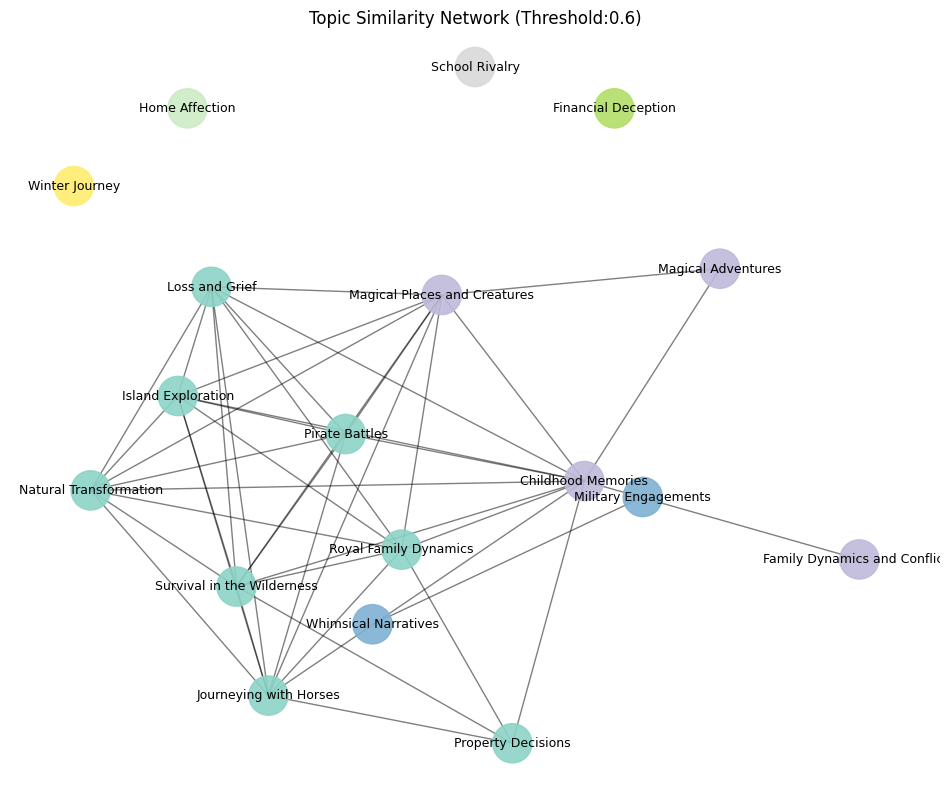

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# Detect communities (Louvain or greedy modularity)
communities = community.greedy_modularity_communities(G)

# Assign colors by community
color_map = {}
for i, com in enumerate(communities):
    for node in com:
        color_map[node] = i

node_colors = [color_map[node] for node in G.nodes()]

# Use Kamada-Kawai layout (often clearer)
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=800, cmap=plt.cm.Set3,
                       node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: G.nodes[i]['label'] for i in G.nodes}, font_size=9)

plt.title(f"Topic Similarity Network (Threshold:{threshold})")
plt.axis("off")
plt.show()

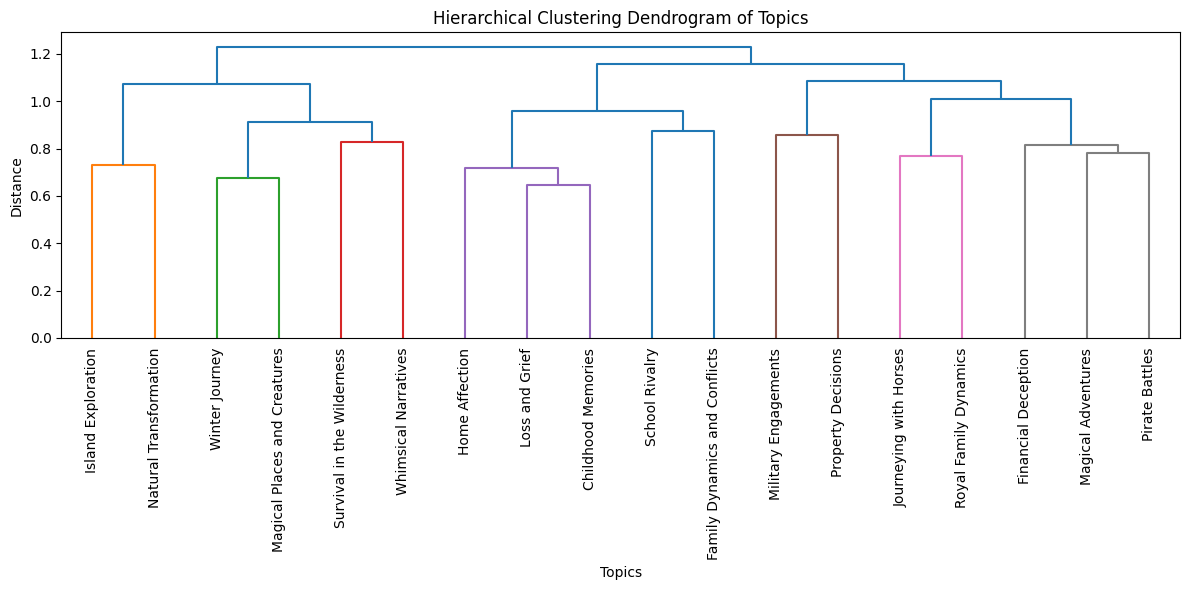

In [47]:
# Hierarchical clustering (using cosine distance)
# Cosine distance = 1 - cosine similarity
from scipy.spatial.distance import pdist, squareform
distance_matrix = pdist(topic_embeddings, metric="cosine")
linkage_matrix = linkage(distance_matrix, method="ward")

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    labels=topic_labels,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.7 * max(linkage_matrix[:, 2])  # adjust threshold
)
plt.title("Hierarchical Clustering Dendrogram of Topics")
plt.xlabel("Topics")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

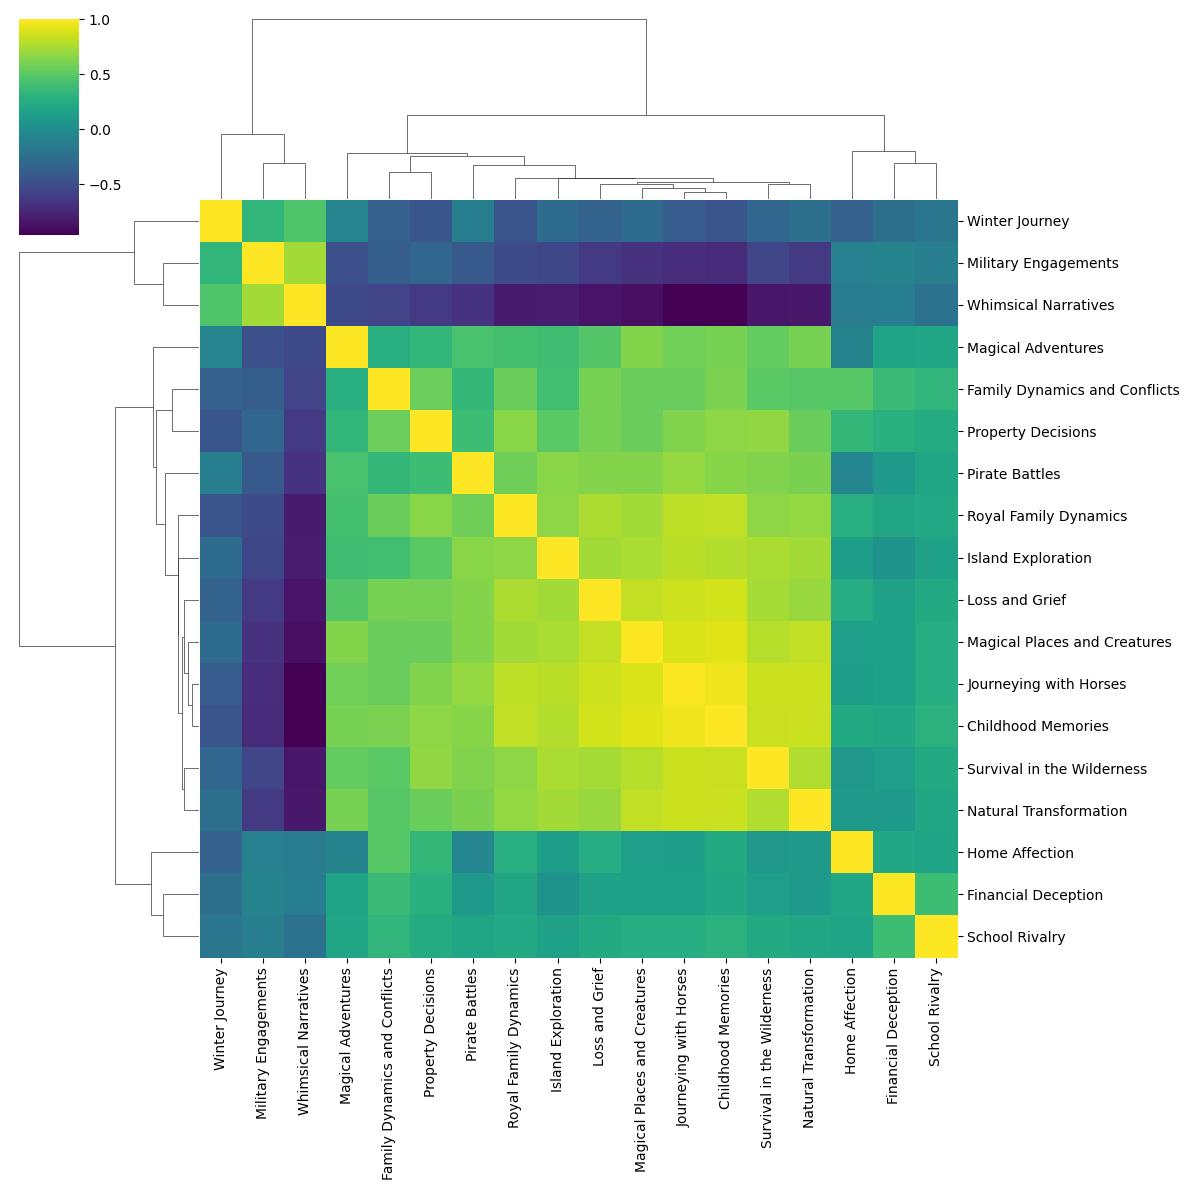

In [48]:
# Clustered heatmap
sns.clustermap(
    similarity_matrix,
    row_cluster=True,
    col_cluster=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    cmap="viridis",
    figsize=(12, 12)
)

plt.show()

## Topic distribution per documents

In [13]:
def topic_relevance_hatmap(agg_df, figsize=(12, 16), title="Topic Relevance per Original Text"):
    # Plot heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(agg_df, annot=False, cmap="YlGnBu", fmt=".2f")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.title(title)
    plt.xlabel("Topics")
    plt.ylabel("Original Texts")
    plt.tight_layout()
    plt.show()

In [18]:
# Add document original information (book, chapter)
n_topics = len(final_model['topics'])
df_topics = pd.DataFrame(final_model['topic-document-matrix'].T, columns=topic_labels)
df_topics['book_id'] = df_chilit['book_id'].to_list()
df_topics['chapter_num'] = df_chilit['chapter_num'].to_list()


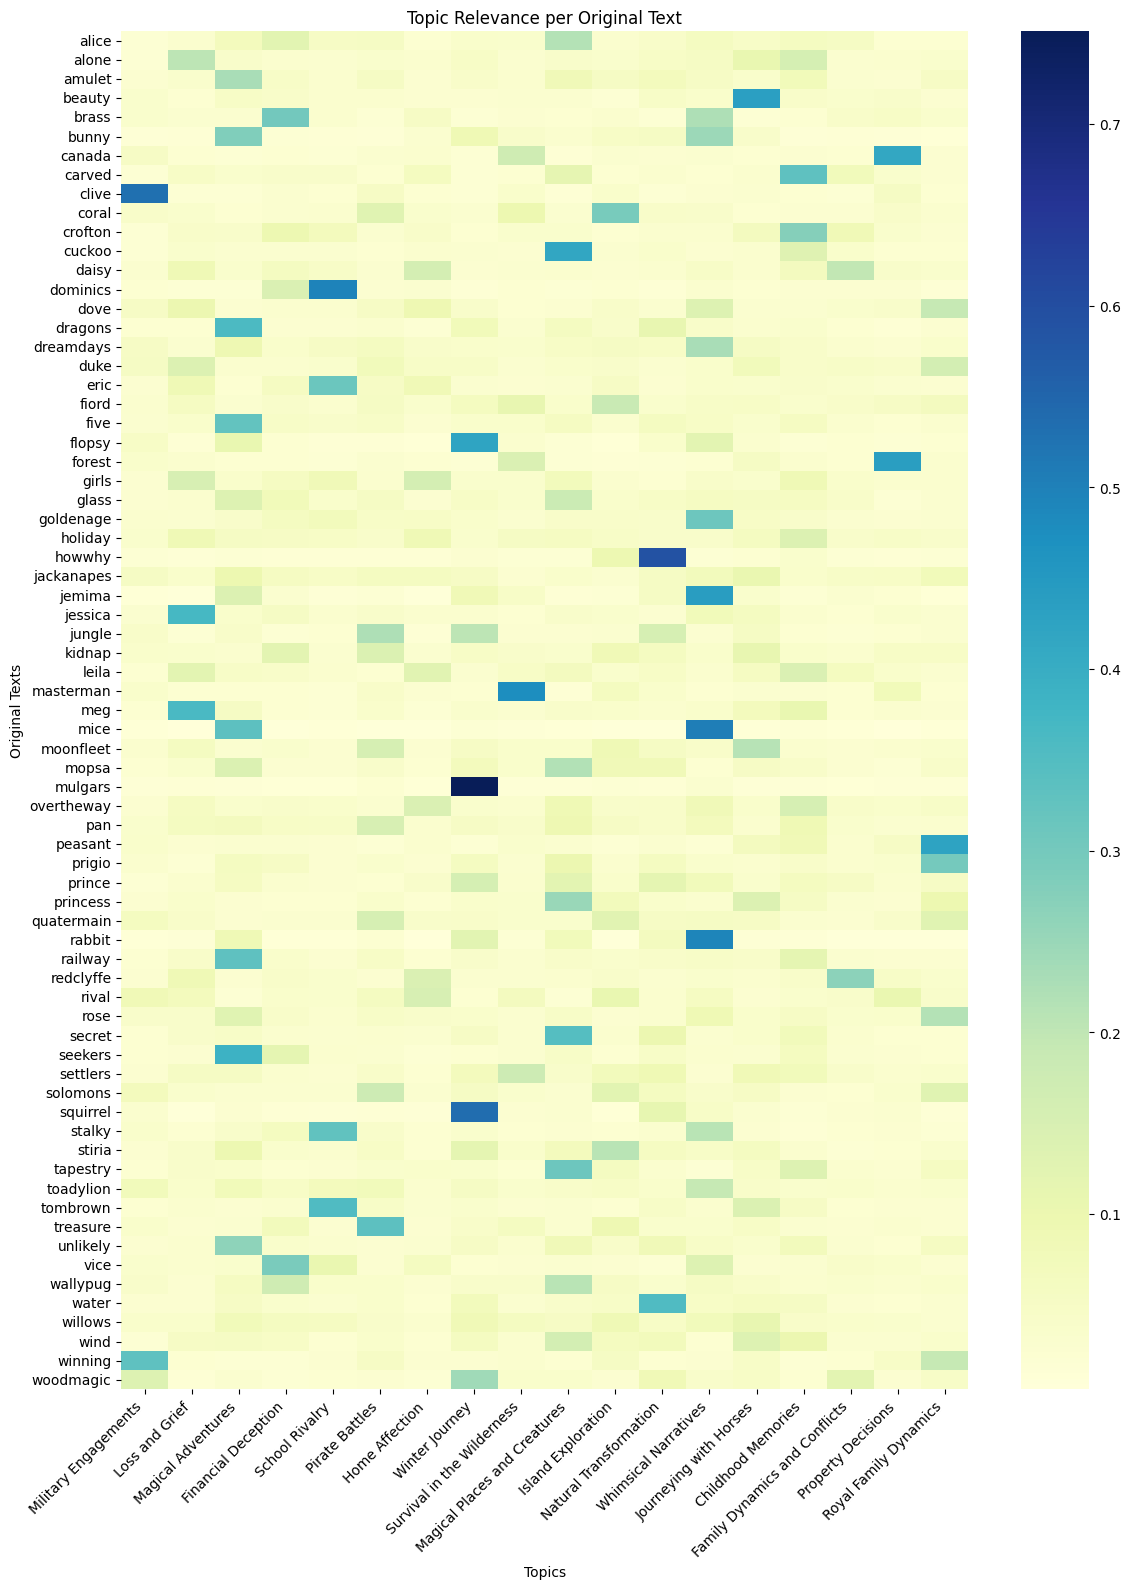

In [19]:
# Aggreagate topics by book
agg_df = df_topics.drop(['chapter_num'], axis=1).groupby("book_id").mean()
# Display heatmap
topic_relevance_hatmap(agg_df)

In [16]:
# Topic relevance by author gender
def topic_relevance_by_gender(agg_df, gender):
    authors = df_authors[df_authors['gender'] == gender]['author'].tolist()
    books = df_metadata[df_metadata['author'].isin(authors)]['shorttitle'].tolist()
    df_temp = agg_df.reset_index()
    filtered_agg_df = df_temp[df_temp['book_id'].isin(books)]
    filtered_agg_df.set_index('book_id', inplace=True)
    topic_relevance_hatmap(filtered_agg_df,figsize=(12, 10), title=f"Topic relevance - {gender} authors")

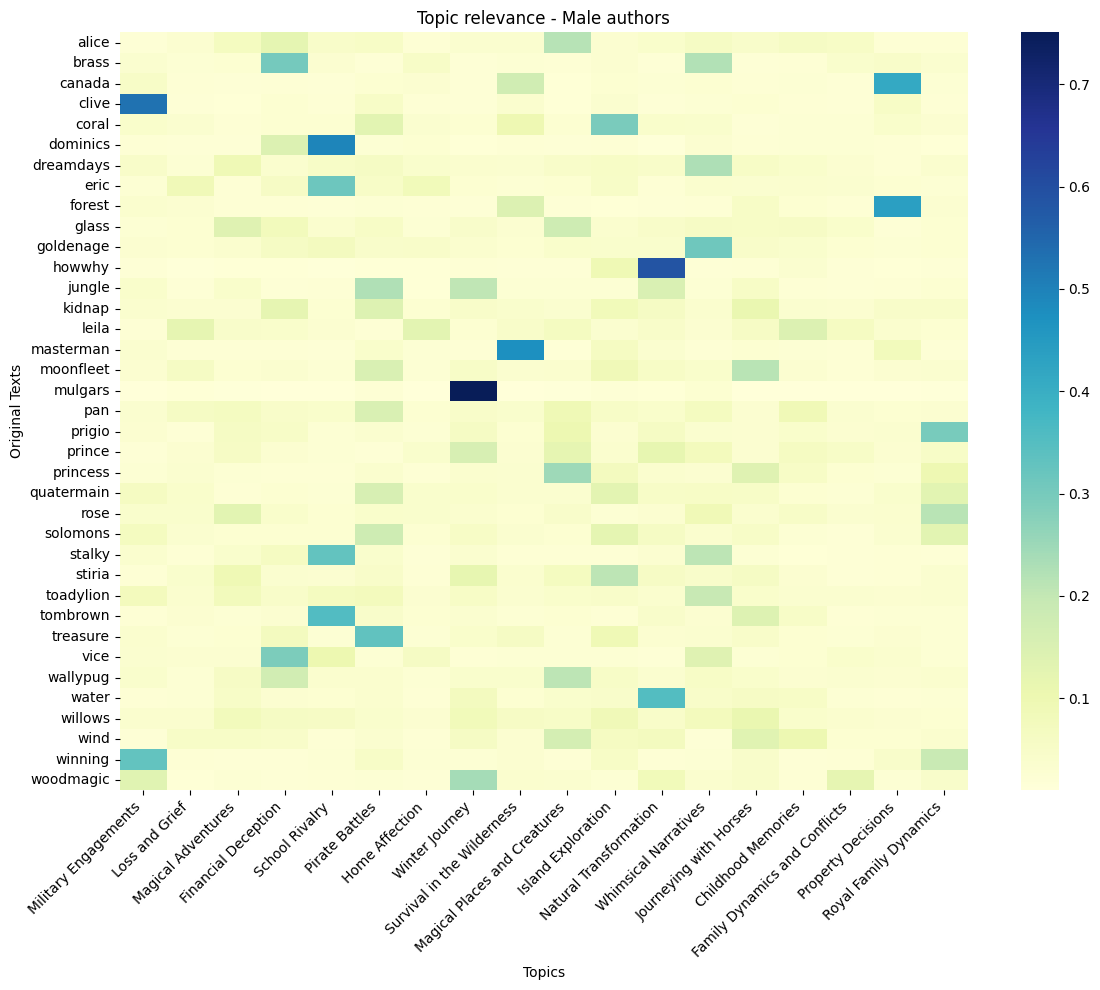

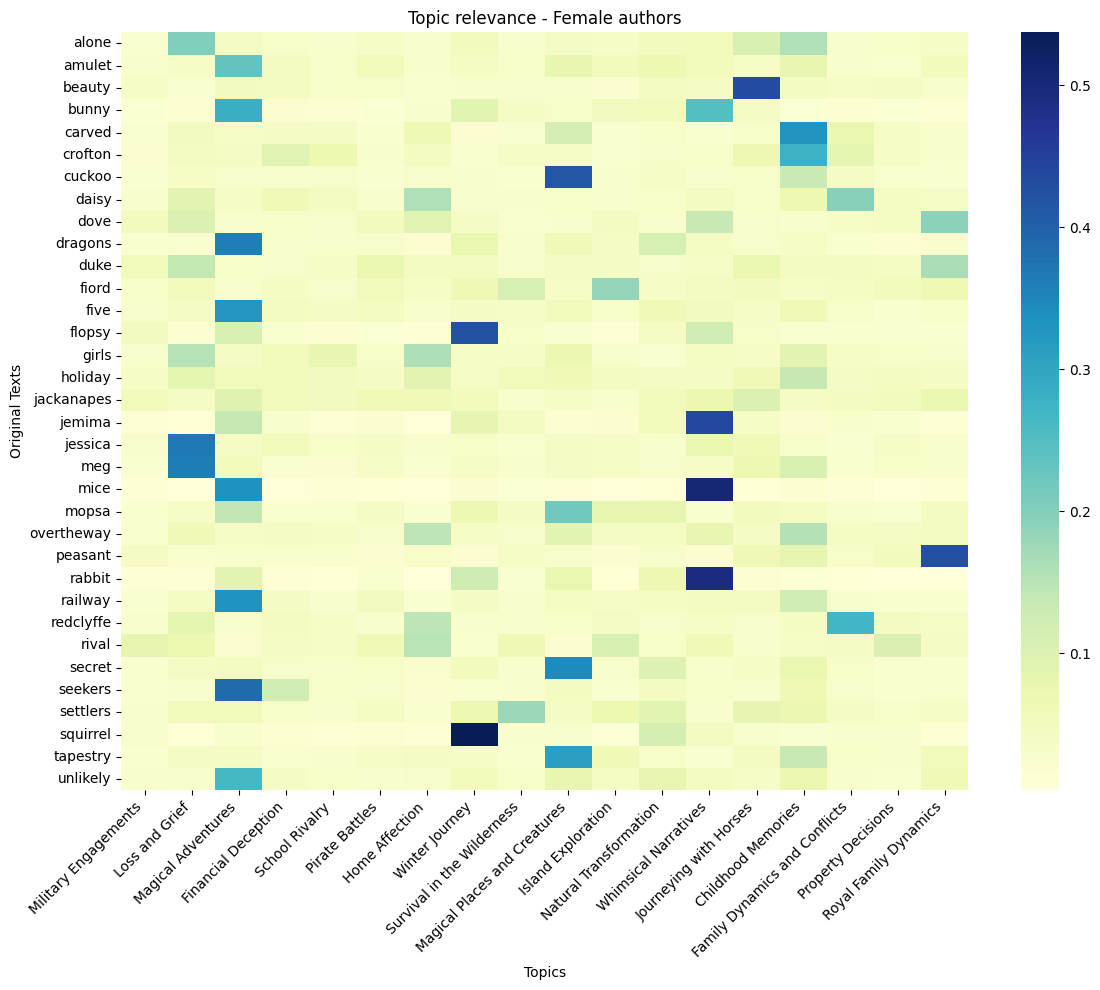

In [20]:
topic_relevance_by_gender(agg_df, 'Male')
topic_relevance_by_gender(agg_df, 'Female')

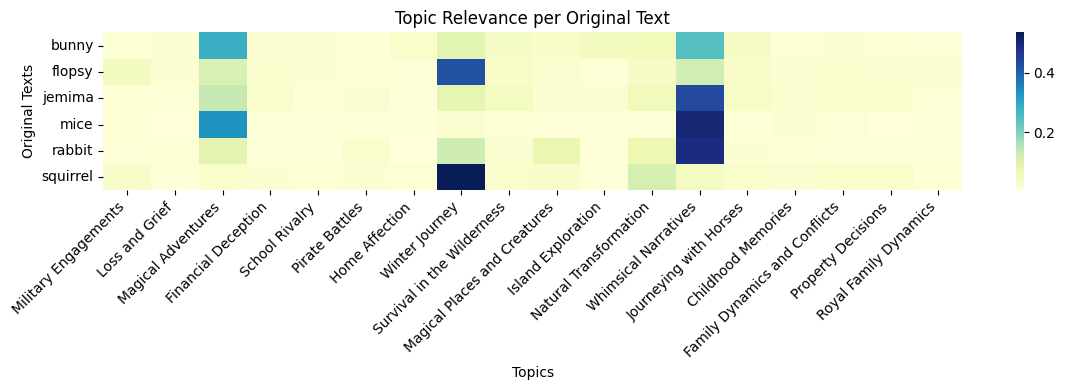

In [81]:
# Topics relevance by author
authors = ['Potter, B.']
books = df_metadata[df_metadata['author'].isin(authors)]['shorttitle'].tolist()
df_temp = agg_df.reset_index()
filtered_agg_df = df_temp[df_temp['book_id'].isin(books)]
filtered_agg_df.set_index('book_id', inplace=True)
topic_relevance_hatmap(filtered_agg_df,figsize=(12, 4))

#### Topic relevance per chapter

In [62]:

par_df = df_topics.groupby(["book_id","chapter_num"]).sum()
par_df = par_df.reset_index()
par_df['doc_id'] =  par_df.apply(lambda row: row['book_id'] + '_' + str(row['chapter_num']), axis=1)

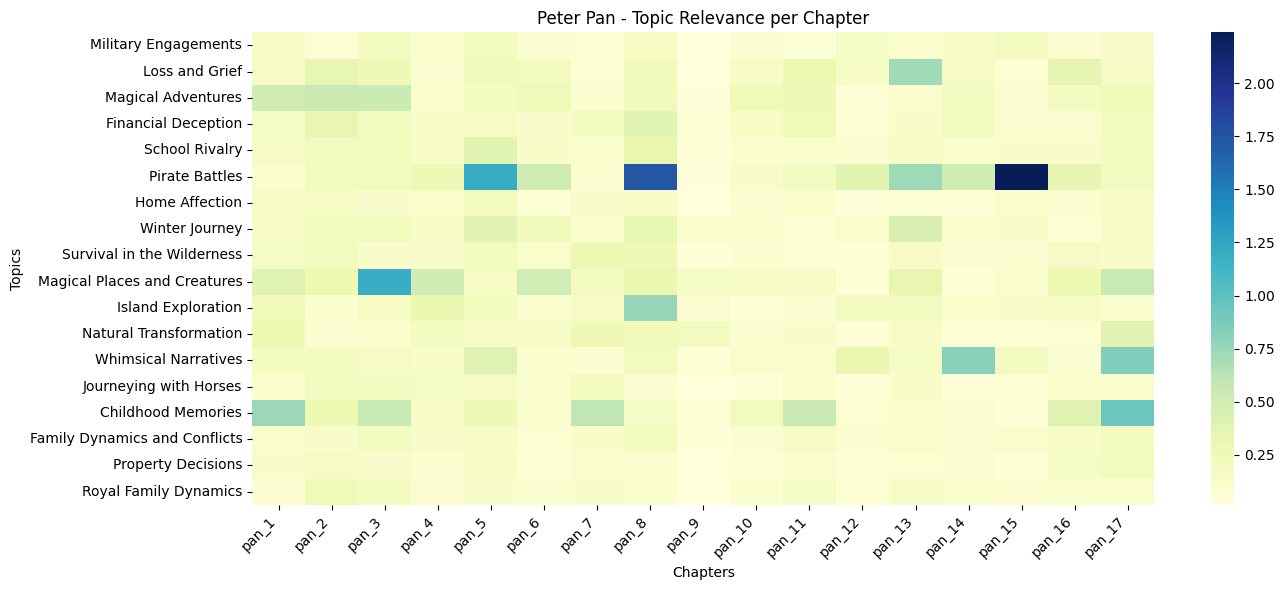

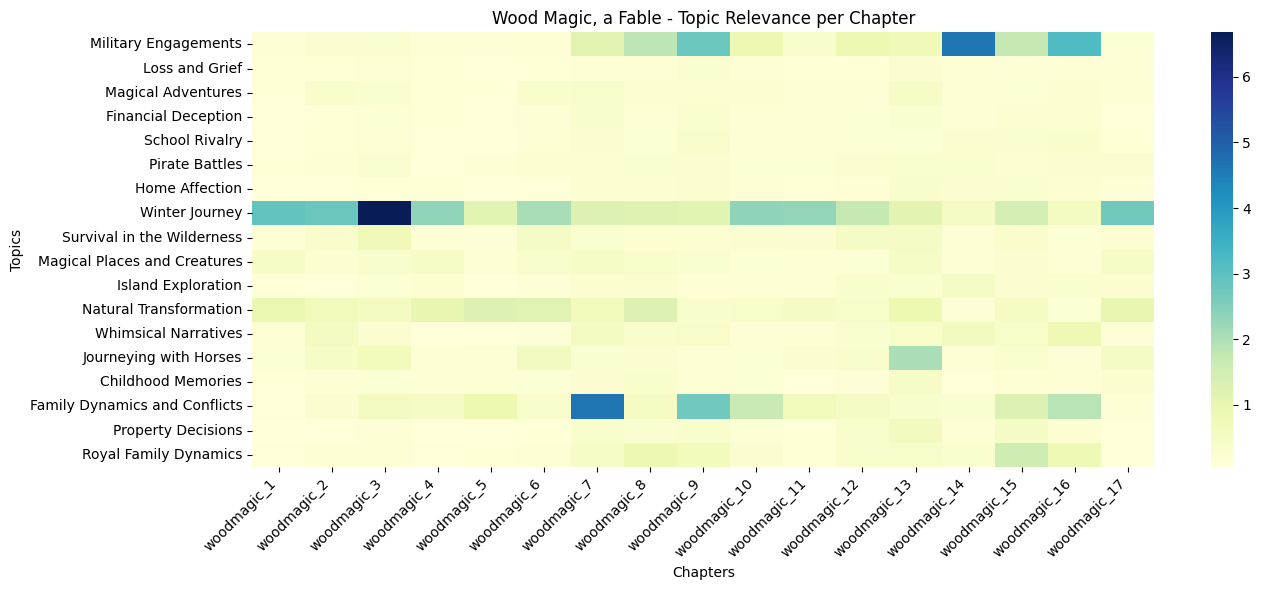

In [85]:
# All books -> books = agg_df['book_id'].unique()
books = ['pan','woodmagic']

for book_id in books:
    title = df_metadata[df_metadata['shorttitle'] == book_id]['title'].item()
    book_df = par_df[par_df['book_id'] == book_id]
    book_df = book_df.drop(['book_id','chapter_num'], axis=1)
    book_df = book_df.set_index('doc_id')

    # Plot heatmap
    plt.figure(figsize=(14, 6))  # wider for readability
    ax = sns.heatmap(book_df.T, annot=False, cmap="YlGnBu", fmt=".2f")

    # Rotate chapter labels (now on x-axis)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Rotate topic labels (now on y-axis)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.title(title + " - " + "Topic Relevance per Chapter")
    plt.xlabel("Chapters")
    plt.ylabel("Topics")
    plt.tight_layout()
    plt.show()

### PCA

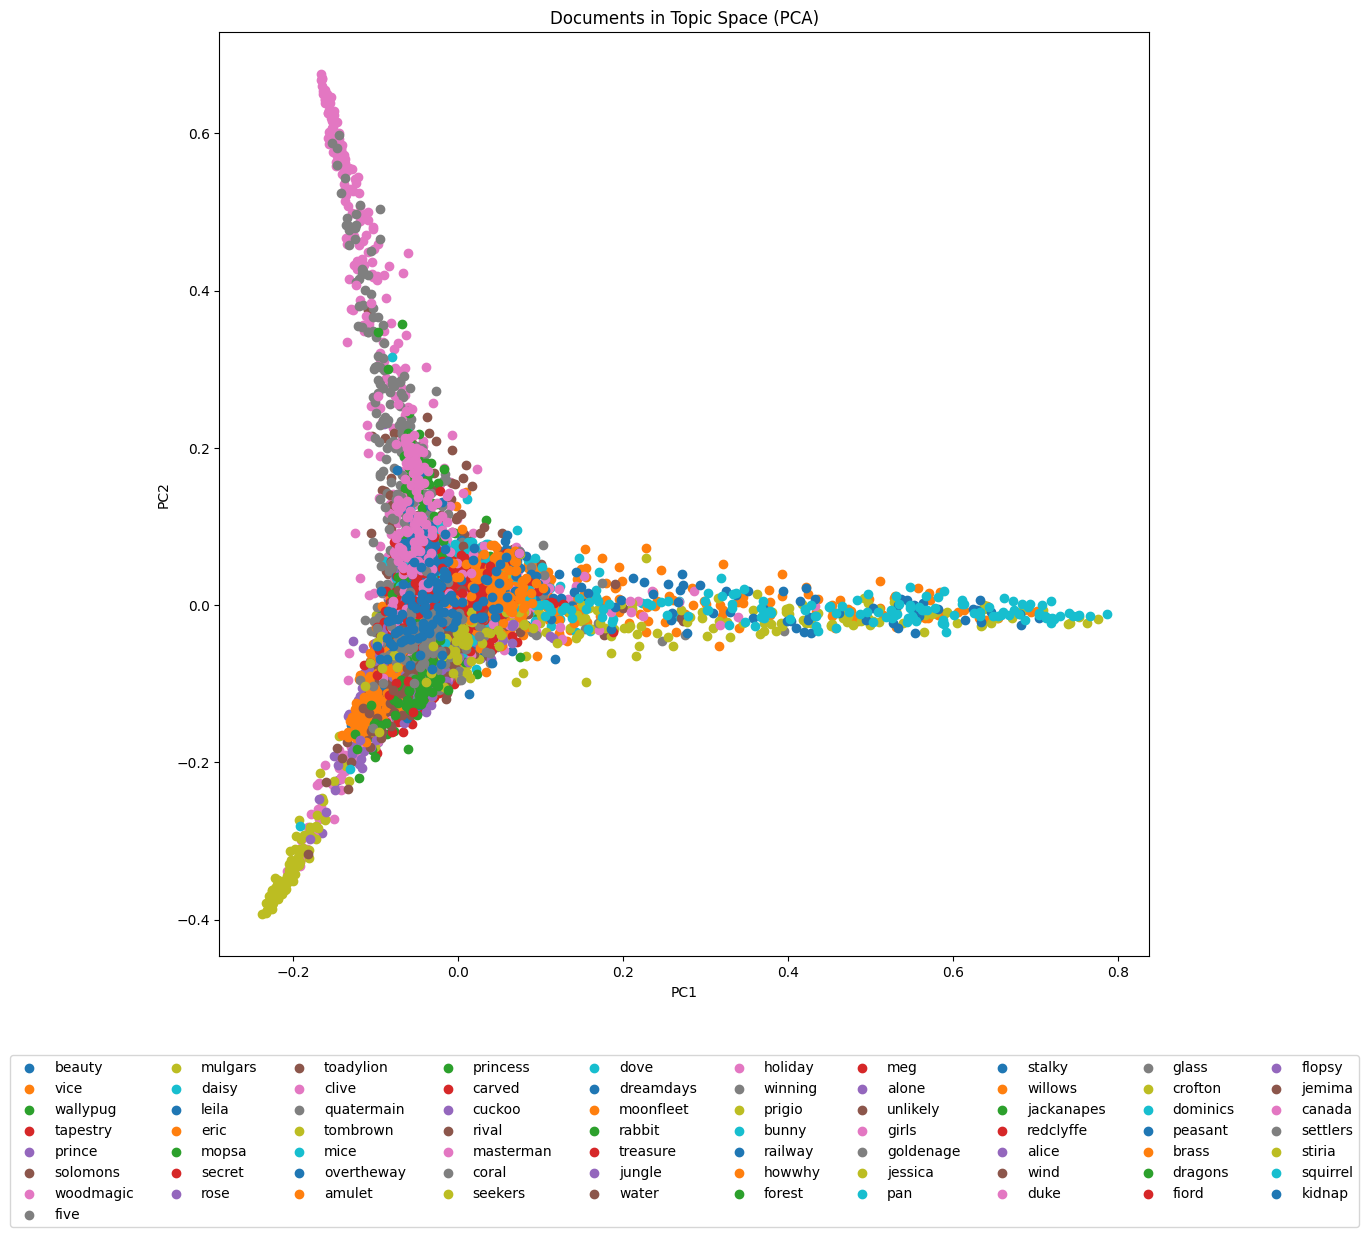

In [21]:
# 2D scatter plot of documents in topic space (PCA)
topic_doc_matrix = final_model['topic-document-matrix'].T
chunk_to_text_map = df_chilit['book_id'].to_list()
pca = PCA(n_components=2)
coords = pca.fit_transform(topic_doc_matrix)
plt.figure(figsize=(12,12))
for text in set(chunk_to_text_map):
    idxs = [i for i, t in enumerate(chunk_to_text_map) if t == text]
    plt.scatter(coords[idxs, 0], coords[idxs, 1], label=text)
plt.title("Documents in Topic Space (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(
    loc="upper center",            # position relative to bbox
    bbox_to_anchor=(0.5, -0.1),    # x = center, y = slightly below axes
    ncol=10                        # arrange items in columns
)

#plt.tight_layout()  # adjust layout so labels/legend fit
plt.show()


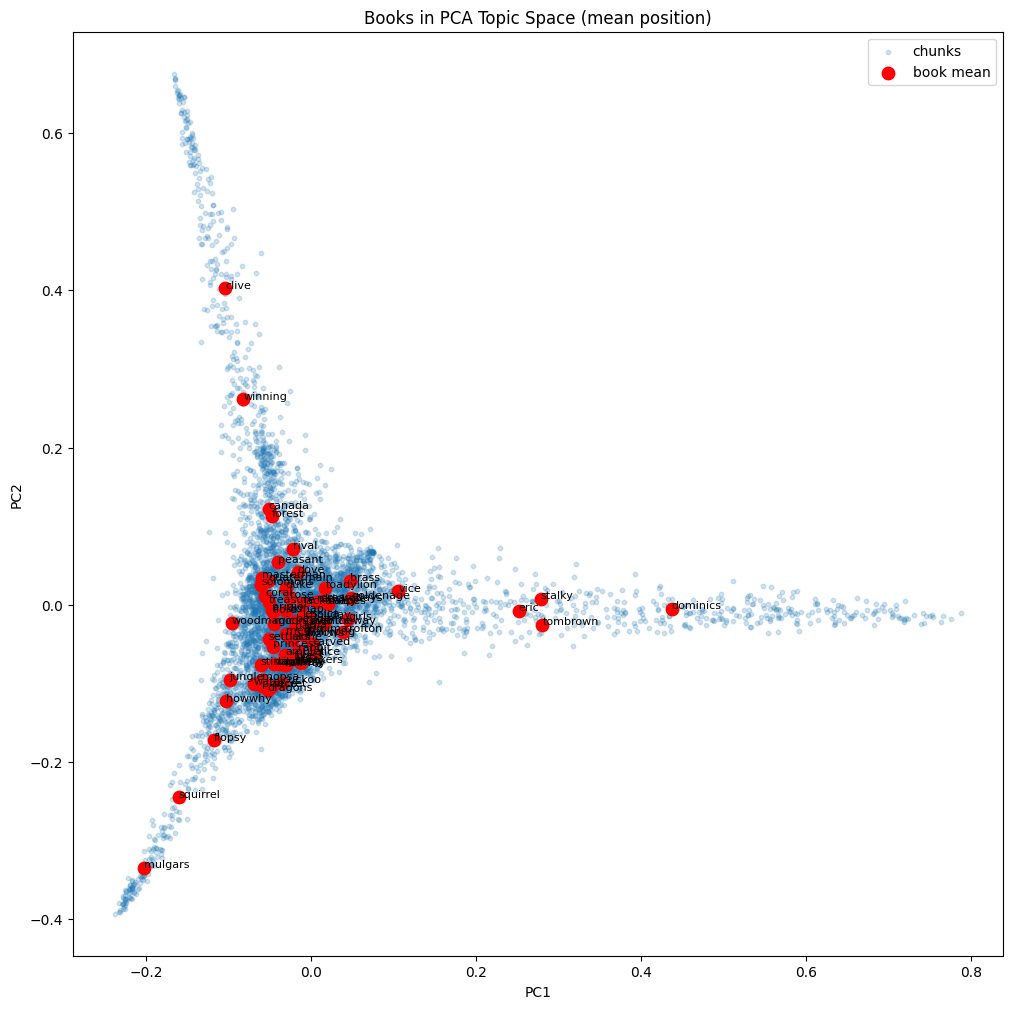

In [25]:
# Store PCA coords with book IDs
coords_df = pd.DataFrame(coords, columns=["PC1", "PC2"])
coords_df["book_id"] = chunk_to_text_map

# Compute mean position for each book
book_means = coords_df.groupby("book_id")[["PC1", "PC2"]].mean()

# Plot average book positions
plt.figure(figsize=(12,12))
plt.scatter(coords[:,0], coords[:,1], alpha=0.2, s=10, label="chunks")  # background chunks
plt.scatter(book_means["PC1"], book_means["PC2"], c="red", s=80, label="book mean")
for book, row in book_means.iterrows():
    plt.text(row["PC1"], row["PC2"], book, fontsize=8)

plt.title("Books in PCA Topic Space (mean position)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

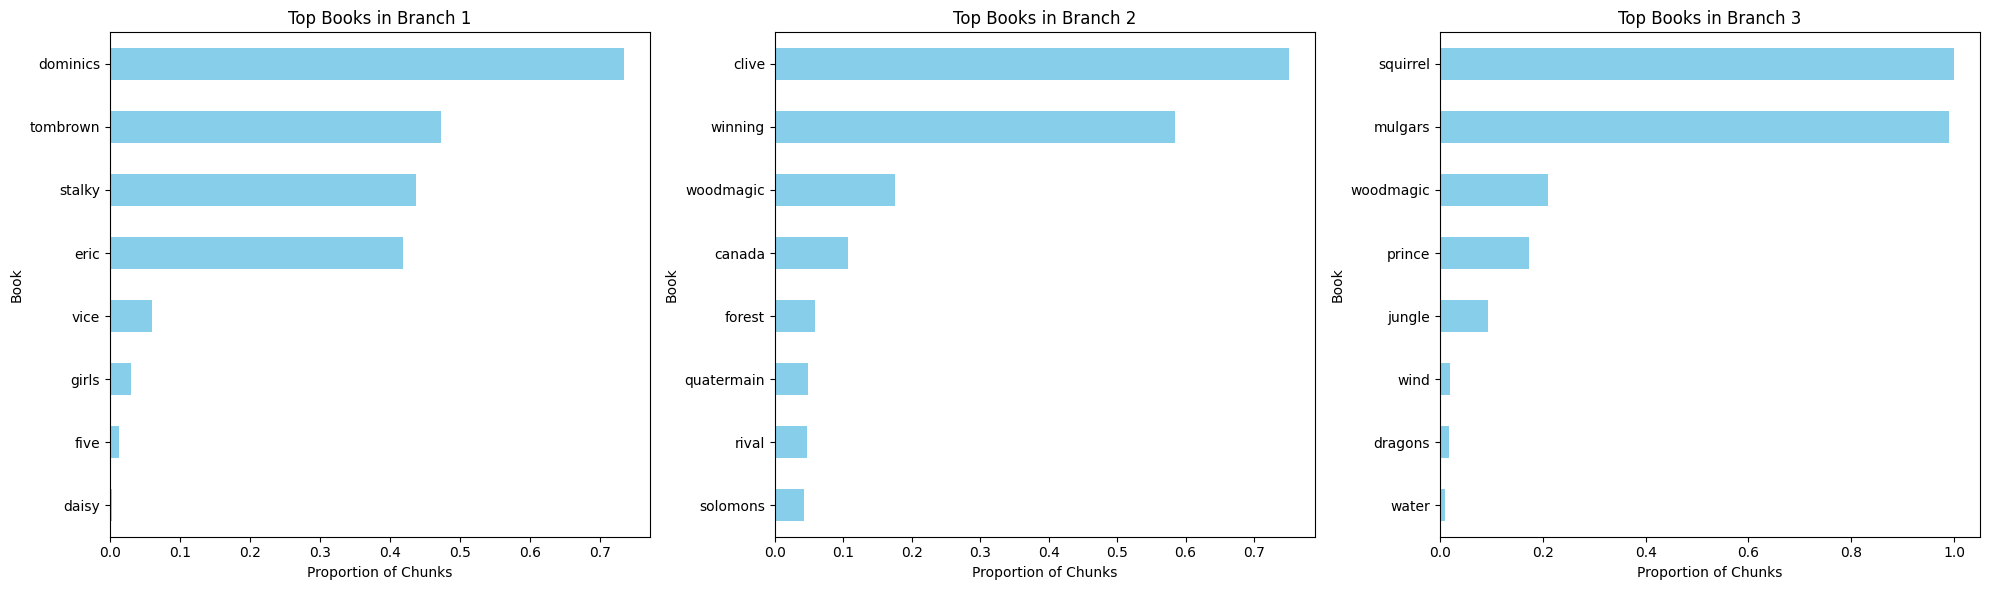

In [80]:
# Assign chunks to branches
def assign_branch(row):
    if row["PC1"] > 0.3:
        return "Branch 1"
    elif row["PC2"] > 0.2:
        return "Branch 2"
    elif row["PC2"] < -0.2:
        return "Branch 3"
    else:
        return "Center"

# Count branch membership per book
coords_df["branch"] = coords_df.apply(assign_branch, axis=1)
branch_counts = coords_df.groupby(["book_id", "branch"]).size().unstack(fill_value=0)
branch_counts["total"] = branch_counts.sum(axis=1)

# Normalize to proportions (so longer books don't dominate just by size)
branch_props = branch_counts.div(branch_counts["total"], axis=0)

top_books_per_branch = {}
for branch in ["Branch 1", "Branch 2", "Branch 3"]:
    top_books_per_branch[branch] = branch_props[branch].sort_values(ascending=False).head(8)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (branch, series) in zip(axes, top_books_per_branch.items()):
    series.plot(kind="barh", ax=ax, color="skyblue")
    ax.set_title(f"Top Books in {branch}")
    ax.set_xlabel("Proportion of Chunks")
    ax.invert_yaxis()  # top book at top
    ax.set_ylabel("Book")  # force y-label visible

plt.tight_layout()
plt.show()


In [79]:
import dash
from dash import dcc, html, Input, Output, callback
import plotly.graph_objects as go

# Your existing PCA computation
topic_doc_matrix = final_model['topic-document-matrix'].T
chunk_to_text_map = df_chilit['book_id'].to_list()
pca = PCA(n_components=2)
coords = pca.fit_transform(topic_doc_matrix)

# Create a DataFrame for easier handling with Plotly
df_plot = pd.DataFrame({
    'PC1': coords[:, 0],
    'PC2': coords[:, 1],
    'book_id': chunk_to_text_map,
    'point_id': range(len(chunk_to_text_map))
})

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Interactive PCA Scatter Plot", style={'text-align': 'center'}),

    html.Div([
        html.Label("Select Books to Highlight:"),
        dcc.Dropdown(
            id='book-dropdown',
            options=[{'label': book, 'value': book} for book in sorted(set(chunk_to_text_map))],
            value=['squirrel', 'bunny', 'mice', 'rabbit', 'jemima', 'flopsy'],  # Default to first 3 books
            multi=True,
            style={'margin-bottom': '20px'}
        )
    ], style={'width': '48%', 'display': 'inline-block'}),

    dcc.Graph(id='scatter-plot', style={'width': '1000px', 'height': '1200px'})
])

@app.callback(
    Output('scatter-plot', 'figure'),
    Input('book-dropdown', 'value')
)
def update_scatter_plot(selected_books):
    fig = go.Figure()

    unique_books = sorted(set(chunk_to_text_map))
    colors = px.colors.qualitative.Set3

    for i, book in enumerate(sorted(unique_books)):
        book_mask = df_plot['book_id'] == book
        book_data = df_plot[book_mask]

        # Determine opacity and size based on selection
        if book in selected_books:
            opacity = 0.8
            size = 10
            line_width = 2
        else:
            opacity = 0.2
            size = 6
            line_width = 0

        fig.add_trace(go.Scatter(
            x=book_data['PC1'],
            y=book_data['PC2'],
            mode='markers',
            name=book,
            marker=dict(
                color=colors[i % len(colors)],
                size=size,
                opacity=opacity,
                line=dict(width=line_width, color='darkslategray')
            ),
            hovertemplate=f'<b>{book}</b><br>' +
                         'PC1: %{x:.3f}<br>' +
                         'PC2: %{y:.3f}<br>' +
                         '<extra></extra>'
        ))

    fig.update_layout(
        title='Documents in Topic Space (PCA)',
        xaxis_title='PC1',
        yaxis_title='PC2',
        hovermode='closest',
        legend=dict(orientation="h", yanchor="top", y=-0.1, xanchor="center", x=0.5)
    )

    return fig


app.run(debug=True)

<IPython.core.display.Javascript object>